In [1]:
import pandas as pd

# dataset load

In [14]:
us_1 = pd.read_csv("chaos_dataset/usa_dream_study_month1.csv")
us_2 = pd.read_csv("chaos_dataset/usa_dream_study_month2.csv")
us_3 = pd.read_csv("chaos_dataset/usa_dream_study_month3.csv")
us_4 = pd.read_csv("chaos_dataset/usa_dream_study_month4.csv")
us_5 = pd.read_csv("chaos_dataset/usa_dream_study_month5.csv")

In [15]:
# Combine all monthly Argentina dataframes
us_all = pd.concat([us_1, us_2, us_3, us_4, us_5], ignore_index=True)

# Check the result
print(us_all.shape)
us_all.head()

(1025, 92)


,ParticipantID,Timepoint,Country,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,...,More_CoffeeCups,More_CoffeeTime,More_Stimulants,More_AlcoholFreq,More_AlcoholAmount,More_Cigarettes,More_LivingSituation,More_Pets,ProlificID,PROLIFIC_PID
0,P0000,1,USA,2024-03-21 09:01:00,2024-03-21 09:23:39,IP Address,192.168.140.63,100,1359,True,...,NaN,12-3pm,No,Monthly or less,10+ drinks,No,Alone,No,P3585650756,P3585650756
1,P0001,1,USA,2024-03-18 11:45:00,2024-03-18 12:06:05,IP Address,192.168.214.57,100,1265,True,...,3.0,Before noon,No,Twice a week,1-2 drinks,No,Alone,Yes,P2631775357,P2631775357
2,P0002,1,USA,2024-03-12 21:22:00,2024-03-12 21:42:18,IP Address,192.168.135.207,100,1218,True,...,5.0,3-6pm,No,2-4 times a month,10+ drinks,Daily,With partner and children,No,P1298737106,P1298737106
3,P0003,1,USA,2024-03-22 11:49:00,2024-03-22 12:03:56,IP Address,192.168.40.219,100,896,True,...,3.0,12-3pm,No,Monthly or less,5-6 drinks,No,Alone,Yes,P9896606039,P9896606039
4,P0004,1,USA,2024-03-21 10:34:00,2024-03-21 10:56:26,IP Address,192.168.125.42,100,1346,True,...,3.0,After 6pm,No,Monthly or less,5-6 drinks,No,With roommates,No,P1284277889,P1284277889


# data cleaning

In [16]:
# Basic structure
us_all.info()

# Check for duplicate columns
print(us_all.columns[us_all.columns.duplicated()])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 92 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ParticipantID           1025 non-null   object 
 1   Timepoint               1025 non-null   int64  
 2   Country                 1025 non-null   object 
 3   StartDate               1025 non-null   object 
 4   EndDate                 1025 non-null   object 
 5   Status                  1025 non-null   object 
 6   IPAddress               1025 non-null   object 
 7   Progress                1025 non-null   int64  
 8   Duration (in seconds)   1025 non-null   int64  
 9   Finished                1025 non-null   bool   
 10  RecordedDate            1025 non-null   object 
 11  ResponseId              1025 non-null   object 
 12  RecipientLastName       0 non-null      float64
 13  RecipientFirstName      0 non-null      float64
 14  RecipientEmail          0 non-null      

In [29]:
# ======================================================
# DREAM STUDY: U.S. DATA CLEANING + ELIGIBILITY + IMPUTATION
# Consistent code style across pipeline
# ======================================================

import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer

# ------------------------------------------------------
# 1. BASE CLEANING PIPELINE
# ------------------------------------------------------

df_us = us_all.copy()

# 1. Drop fully empty columns
df_us = df_us.dropna(axis=1, how="all")

# 2. Standardize Timepoint and ParticipantID
df_us["Timepoint"] = pd.to_numeric(df_us["Timepoint"], errors="coerce").astype("Int64")
df_us = df_us[df_us["Timepoint"].between(1, 5, inclusive="both")]

pid = (
    df_us["ParticipantID"].astype(str).str.upper().str.strip().str.extract(r"(\d+)")[0]
)
df_us["ParticipantID"] = np.where(
    pid.notna(),
    pid.astype(int).apply(lambda x: f"P{x:04d}"),
    df_us["ParticipantID"].astype(str).str.upper().str.strip(),
)

# 3. Parse date columns
for c in ["StartDate", "EndDate", "RecordedDate"]:
    if c in df_us.columns:
        df_us[c] = pd.to_datetime(df_us[c], errors="coerce")

# 4. Drop duplicates
df_us = df_us.drop_duplicates()
df_us = (
    df_us.sort_values(["ParticipantID", "Timepoint", "RecordedDate"])
    .drop_duplicates(subset=["ParticipantID", "Timepoint"], keep="last")
    .reset_index(drop=True)
)

# 5. Keep only valid/finished entries
if {"Finished", "Progress"}.issubset(df_us.columns):
    df_us = df_us[(df_us["Finished"] == True) | (df_us["Progress"] >= 80)]

# 6. Basic duration filter (optional)
if "Duration (in seconds)" in df_us.columns:
    dur = pd.to_numeric(df_us["Duration (in seconds)"], errors="coerce")
    df_us = df_us[(dur.isna()) | ((dur >= 60) & (dur <= 3 * 60 * 60))]

# 7. Sort and summarize
df_us = df_us.sort_values(["ParticipantID", "Timepoint"]).reset_index(drop=True)

print(f"Rows after cleaning: {len(df_us)}")
print(f"Unique participants: {df_us['ParticipantID'].nunique()}")
print("Timepoint counts:")
print(df_us["Timepoint"].value_counts().sort_index())

# Save cleaned file
df_us.to_csv("chaos_dataset/us_clean.csv", index=False)
print("✅ Saved cleaned file: chaos_dataset/us_clean.csv")

Rows after cleaning: 923
Unique participants: 200
Timepoint counts:
Timepoint
1    188
2    183
3    184
4    183
5    185
Name: count, dtype: Int64
✅ Saved cleaned file: chaos_dataset/us_clean.csv


In [31]:
# ------------------------------------------------------
# 2. IMPUTATION + ELIGIBILITY PIPELINE
# ------------------------------------------------------


def apply_rules_us(df_raw, dream_min_words=10, mice_m=20, mice_seed=2025):
    df = df_raw.copy()

    # --- Drop empty columns ---
    df = df.dropna(axis=1, how="all")

    # --- Age exclusion ---
    age_col = next(
        (
            c
            for c in df.columns
            if c.lower() in ["age", "participant_age", "respondentage"]
        ),
        None,
    )
    if age_col:
        df[age_col] = pd.to_numeric(df[age_col], errors="coerce")
        before = len(df)
        df = df[df[age_col] >= 18]
        print(f"Removed {before - len(df)} rows (under 18).")

    # --- NLP eligibility flag (Dream_Content column) ---
    if "DreamMemory" in df.columns:
        text = df["DreamMemory"].fillna("").astype(str).str.strip()
        df["NLP_Eligible"] = text.str.split().apply(len) >= dream_min_words
        df["Dream_WordCount"] = text.str.split().apply(len)
        print(
            f"NLP-eligible dreams: {df['NLP_Eligible'].sum()} / {len(df)} "
            f"({df['NLP_Eligible'].mean():.2%})"
        )
    else:
        df["NLP_Eligible"] = np.nan
        df["Dream_WordCount"] = np.nan
        print("⚠️  'Dream_Content' column not found; NLP_Eligible skipped.")

    # --- Missingness summary ---
    miss_pct = df.isna().mean().mul(100)
    missingness = miss_pct.rename("pct_missing").to_frame()
    print("\nTop missingness:")
    print(missingness.sort_values("pct_missing", ascending=False).head(10))

    # --- Identify numeric and categorical vars for imputation ---
    exclude = {
        "ParticipantID",
        "Country",
        "ResponseId",
        "PROLIFIC_PID",
        "UserLanguage",
        "StartDate",
        "EndDate",
        "RecordedDate",
        "Status",
        "IPAddress",
        "Dream_Content",
    }
    exclude = {c for c in exclude if c in df.columns}

    num_cols = df.select_dtypes(include=["number"]).columns.difference(list(exclude))
    cat_cols = df.select_dtypes(
        include=["object", "category", "boolean"]
    ).columns.difference(list(exclude))

    # keep only those with >5% missing and not all-NaN
    num_mice_cols = [
        c for c in num_cols if df[c].isna().mean() > 0.05 and df[c].notna().any()
    ]
    cat_imp_cols = [
        c for c in cat_cols if df[c].isna().mean() > 0.05 and df[c].notna().any()
    ]

    print(f"\nNumeric columns to MICE: {num_mice_cols}")
    print(f"Categorical to impute (most_frequent): {cat_imp_cols}")

    # --- Imputation ---
    imputed_datasets = []
    for m in range(mice_m):
        dfi = df.copy()

        # Categorical
        if cat_imp_cols:
            simputer = SimpleImputer(strategy="most_frequent")
            dfi[cat_imp_cols] = simputer.fit_transform(dfi[cat_imp_cols])

        # Numeric
        if num_mice_cols:
            subset = dfi[num_mice_cols]
            mice = IterativeImputer(
                random_state=mice_seed + m,
                sample_posterior=True,
                max_iter=20,
                initial_strategy="median",
            )
            imputed_array = mice.fit_transform(subset)
            dfi[num_mice_cols] = imputed_array

        dfi[".imputation"] = m + 1
        imputed_datasets.append(dfi)

    print(f"\n✅ Created {len(imputed_datasets)} imputed datasets for US.")
    return {"df_core": df, "missingness": missingness, "mi_datasets": imputed_datasets}


# ---------- Run it ----------
us_out = apply_rules_us(df_us)
df_us_core = us_out["df_core"]
us_missing = us_out["missingness"]
us_imps = us_out["mi_datasets"]

NLP-eligible dreams: 838 / 923 (90.79%)

Top missingness:
                      pct_missing
LocationLatitude        97.074756
LocationLongitude       97.074756
Dream_TalkWhom          56.663055
More_CoffeeCups         43.011918
More_CoffeeTime         31.527627
DreamQ_FeelControl_1    20.585049
GAD_Bothered_4          20.368364
More_AlcoholAmount      20.151679
PHQ_Bothered_6          20.043337
PHQ_Bothered_7          19.934995

Numeric columns to MICE: ['GAD_Total', 'LocationLatitude', 'LocationLongitude', 'More_CoffeeCups', 'PHQ_Total', 'Sleep_Hours']
Categorical to impute (most_frequent): ['DreamQ_Bizarre_1', 'DreamQ_ControlFreq_1', 'DreamQ_FeelControl_1', 'DreamQ_Frequency', 'DreamQ_Recurring', 'DreamQ_Vivid_1', 'Dream_TalkWhom', 'GAD_Bothered_1', 'GAD_Bothered_2', 'GAD_Bothered_3', 'GAD_Bothered_4', 'GAD_Bothered_5', 'GAD_Bothered_6', 'GAD_Bothered_7', 'More_AlcoholAmount', 'More_CoffeeTime', 'More_DreamList', 'PHQ_Bothered_1', 'PHQ_Bothered_2', 'PHQ_Bothered_3', 'PHQ_Bothered_4',

In [32]:
# ------------------------------------------------------
# 3. EXTRACT NLP-ELIGIBLE SUBSET
# ------------------------------------------------------

us_nlp = df_us_core[df_us_core["NLP_Eligible"]].copy()
print(
    f"\n✅ NLP subset size: {len(us_nlp)} dreams ({len(us_nlp)/len(df_us_core):.2%} of total)"
)


✅ NLP subset size: 838 dreams (90.79% of total)


In [41]:
us_nlp.head()

,ParticipantID,Timepoint,Country,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,...,More_Stimulants,More_AlcoholFreq,More_AlcoholAmount,More_Cigarettes,More_LivingSituation,More_Pets,ProlificID,PROLIFIC_PID,NLP_Eligible,Dream_WordCount
0,P0000,1,USA,2024-03-21 09:01:00,2024-03-21 09:23:39,IP Address,192.168.140.63,100,1359,True,...,No,Monthly or less,10+ drinks,No,Alone,No,P3585650756,P3585650756,True,13
1,P0000,2,USA,2024-04-26 18:19:00,2024-04-26 18:43:06,IP Address,192.168.20.56,100,1446,True,...,No,3-4 times a week,5-6 drinks,No,Alone,No,P1746756255,P1746756255,True,14
2,P0000,3,USA,2024-05-20 17:06:00,2024-05-20 17:28:58,IP Address,192.168.39.170,100,1378,True,...,No,2-4 times a month,1-2 drinks,No,Alone,No,P9550041076,P9550041076,True,12
3,P0000,4,USA,2024-06-21 12:46:00,2024-06-21 12:56:06,IP Address,192.168.248.160,100,606,True,...,Yes,Never,NaN,No,Living with partner/family,No,P3232620908,P3232620908,True,13
4,P0000,5,USA,2024-07-29 22:09:00,2024-07-29 22:21:47,IP Address,192.168.212.31,100,767,True,...,No,2-4 times a month,1-2 drinks,No,Alone,No,P4245593049,P4245593049,True,12


# analysis

In [42]:
# ======================================================
# DREAM STUDY: U.S. TEXT FEATURE EXTRACTION
# (Stage 2: Build NLP-derived predictors)
# ======================================================

import spacy
from sentence_transformers import SentenceTransformer
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
import torch
import nltk

nltk.download("vader_lexicon")


# ------------------------------------------------------
# 1. Setup models and helper functions
# ------------------------------------------------------

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm", disable=["ner"])

# Load sentence embedding model for coherence
sbert = SentenceTransformer("all-MiniLM-L6-v2")

# Initialize VADER for sentiment
sia = SentimentIntensityAnalyzer()


def cosine_similarity(a, b):
    """Compute cosine similarity between two numpy vectors."""
    return (
        float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))
        if np.any(a) and np.any(b)
        else np.nan
    )


def compute_text_features(text):
    """Return preregistered NLP metrics for one dream report."""
    text = str(text).strip()
    if not text:
        return {
            "TTR": np.nan,
            "ParseDepth": np.nan,
            "Coherence": np.nan,
            "Sentiment": np.nan,
            "EmotionalTone": np.nan,
        }

    # --- Tokenization and lexical diversity ---
    doc = nlp(text)
    words = [t.text.lower() for t in doc if t.is_alpha]
    ttr = len(set(words)) / len(words) if words else np.nan

    # --- Parse tree depth (syntactic complexity) ---
    depths = [len(list(t.ancestors)) for t in doc if t.dep_ != "punct"]
    parse_depth = np.mean(depths) if depths else np.nan

    # --- Coherence: mean cosine similarity of adjacent sentences ---
    sents = [s.text.strip() for s in doc.sents if len(s.text.strip()) > 1]
    if len(sents) > 1:
        emb = sbert.encode(sents, convert_to_numpy=True, normalize_embeddings=True)
        sims = [cosine_similarity(emb[i], emb[i + 1]) for i in range(len(emb) - 1)]
        coherence = np.nanmean(sims)
    else:
        coherence = np.nan

    # --- Sentiment (VADER compound) ---
    sentiment = sia.polarity_scores(text)["compound"]

    # --- Emotional tone (mean of positive emotion intensities) ---
    try:
        emo = NRCLex(text)
        emotion_values = list(emo.raw_emotion_scores.values())
        emotional_tone = np.mean(emotion_values) if emotion_values else np.nan
    except Exception:
        emotional_tone = np.nan

    return {
        "TTR": ttr,
        "ParseDepth": parse_depth,
        "Coherence": coherence,
        "Sentiment": sentiment,
        "EmotionalTone": emotional_tone,
    }


# ------------------------------------------------------
# 2. Apply feature extraction to NLP-eligible dreams
# ------------------------------------------------------

us_feats = us_nlp["DreamMemory"].apply(compute_text_features).apply(pd.Series)

# Merge features back to main NLP subset
us_ready = pd.concat([us_nlp.reset_index(drop=True), us_feats], axis=1)

print(f"✅ Extracted text features for {len(us_ready)} dreams.")
print(
    us_ready[
        ["TTR", "ParseDepth", "Coherence", "Sentiment", "EmotionalTone"]
    ].describe()
)

# ------------------------------------------------------
# 3. Align PHQ/GAD totals and save
# ------------------------------------------------------

# If totals already exist in raw data
if {"PHQ_Total", "GAD_Total"}.issubset(us_ready.columns):
    us_ready = us_ready.rename(columns={"PHQ_Total": "PHQ9", "GAD_Total": "GAD7"})
    print("✅ Using precomputed PHQ_Total and GAD_Total from raw dataset.")
else:
    # Otherwise, compute them manually
    phq_items = [c for c in us_ready.columns if c.startswith("PHQ_Bothered_")]
    gad_items = [c for c in us_ready.columns if c.startswith("GAD_Bothered_")]

    for col in phq_items + gad_items:
        us_ready[col] = pd.to_numeric(us_ready[col], errors="coerce")

    us_ready["PHQ9"] = us_ready[phq_items].sum(axis=1, skipna=True)
    us_ready["GAD7"] = us_ready[gad_items].sum(axis=1, skipna=True)
    print("✅ Computed PHQ9 and GAD7 from item responses.")

# Check summary
print(us_ready[["PHQ9", "GAD7"]].describe())

# Save feature dataset
us_ready.to_csv("chaos_dataset/us_dream_features.csv", index=False)
print("✅ Saved file: chaos_dataset/us_dream_features.csv")

# Preview key columns
print(
    us_ready[
        ["ParticipantID", "Timepoint", "TTR", "Coherence", "Sentiment", "PHQ9", "GAD7"]
    ].head()
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chensi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


✅ Extracted text features for 917 dreams.
              TTR  ParseDepth   Coherence   Sentiment  EmotionalTone
count  838.000000  838.000000  381.000000  838.000000            0.0
mean     0.975378    1.829882    0.230121   -0.332399            NaN
std      0.037023    0.533427    0.072109    0.304001            NaN
min      0.866667    1.000000    0.091039   -0.884700            NaN
25%      0.928571    1.454545    0.179253   -0.554000            NaN
50%      1.000000    1.666667    0.212682   -0.421500            NaN
75%      1.000000    2.461538    0.278573   -0.102700            NaN
max      1.000000    2.900000    0.415865    0.620400            NaN
✅ Using precomputed PHQ_Total and GAD_Total from raw dataset.
             PHQ9        GAD7
count  694.000000  682.000000
mean     6.321398    6.750337
std      3.452320    3.973172
min      0.000000    0.000000
25%      3.870000    3.830000
50%      6.195000    6.370000
75%      8.860000    9.630000
max     17.070000   18.460000
✅ Sav

# data visualization

Model sample size: 238 dreams from 121 participants

=== Mixed Model: PHQ-9 ~ Dream Features ===
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: PHQ9     
No. Observations: 238     Method:             REML     
No. Groups:       121     Scale:              6.5628   
Min. group size:  1       Log-Likelihood:     -605.7566
Max. group size:  5       Converged:          Yes      
Mean group size:  2.0                                  
-------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------
Intercept   10.862    5.248  2.070 0.038   0.577 21.148
TTR         -4.400    5.242 -0.839 0.401 -14.675  5.875
Coherence    1.128    2.800  0.403 0.687  -4.359  6.615
Sentiment    1.158    0.759  1.525 0.127  -0.330  2.645
Group Var    4.719    0.588                            


=== Mixed Model: GAD-7 ~ Dream Features ===
         Mixed Linear Mode

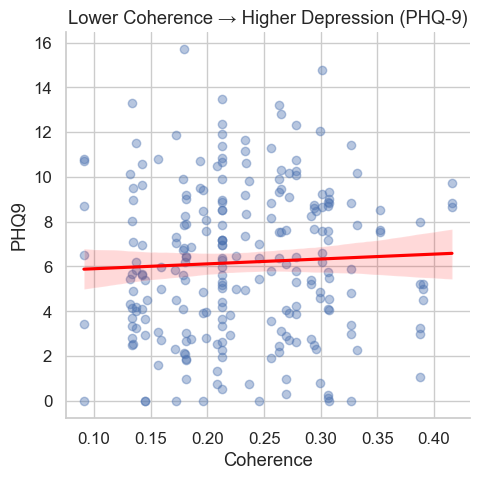

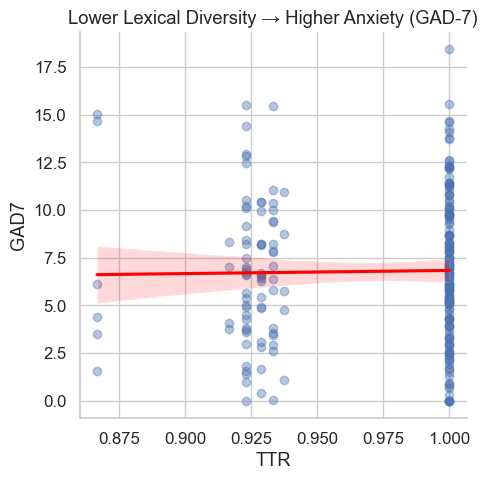

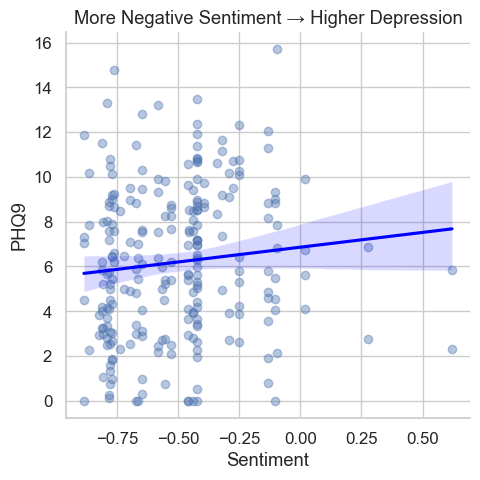


=== Slide-Ready Coefficient Table ===
           Predictor  β_PHQ9  p_PHQ9  β_GAD7  p_GAD7
Intercept  Intercept  10.862   0.038   9.996   0.021
TTR              TTR  -4.400   0.401  -3.247   0.453
Coherence  Coherence   1.128   0.687  -1.825   0.429
Sentiment  Sentiment   1.158   0.127  -0.540   0.396
Group Var  Group Var   0.719   0.002   2.767   0.000
✅ Saved model results: chaos_dataset/us_model_coefficients.csv


In [44]:
# ======================================================
# DREAM STUDY: U.S. MIXED-EFFECTS MODELING & VISUALIZATION
# (Stage 3: RQ2–RQ3 Hypothesis Tests)
# ======================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (6, 4)

# ------------------------------------------------------
# 1. Load data and basic checks
# ------------------------------------------------------
us_ready = pd.read_csv("chaos_dataset/us_dream_features.csv")

# Drop rows missing outcome or predictors
model_df = us_ready.dropna(
    subset=["PHQ9", "GAD7", "TTR", "Coherence", "Sentiment"]
).copy()
print(
    f"Model sample size: {len(model_df)} dreams from {model_df['ParticipantID'].nunique()} participants"
)

# ------------------------------------------------------
# 2. Linear Mixed-Effects Models (LME)
# ------------------------------------------------------
# RQ2: Do structural and emotional features predict depression (PHQ9)?
mdl_phq = smf.mixedlm(
    "PHQ9 ~ TTR + Coherence + Sentiment",
    data=model_df,
    groups=model_df["ParticipantID"],
).fit()
print("\n=== Mixed Model: PHQ-9 ~ Dream Features ===")
print(mdl_phq.summary())

# RQ3: Do the same features predict anxiety (GAD7)?
mdl_gad = smf.mixedlm(
    "GAD7 ~ TTR + Coherence + Sentiment",
    data=model_df,
    groups=model_df["ParticipantID"],
).fit()
print("\n=== Mixed Model: GAD-7 ~ Dream Features ===")
print(mdl_gad.summary())

# ------------------------------------------------------
# 3. Effect Plots (for slides)
# ------------------------------------------------------
# Coherence vs PHQ-9
sns.lmplot(
    x="Coherence",
    y="PHQ9",
    data=model_df,
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "red"},
)
plt.title("Lower Coherence → Higher Depression (PHQ-9)")
plt.tight_layout()
plt.savefig("chaos_dataset/fig_coherence_phq9_model.png", dpi=300)
plt.show()

# TTR vs GAD-7
sns.lmplot(
    x="TTR",
    y="GAD7",
    data=model_df,
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "red"},
)
plt.title("Lower Lexical Diversity → Higher Anxiety (GAD-7)")
plt.tight_layout()
plt.savefig("chaos_dataset/fig_ttr_gad7_model.png", dpi=300)
plt.show()

# Sentiment vs PHQ-9
sns.lmplot(
    x="Sentiment",
    y="PHQ9",
    data=model_df,
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "blue"},
)
plt.title("More Negative Sentiment → Higher Depression")
plt.tight_layout()
plt.savefig("chaos_dataset/fig_sentiment_phq9_model.png", dpi=300)
plt.show()

# ------------------------------------------------------
# 4. Export tidy coefficient table (for slides)
# ------------------------------------------------------
coef_table = pd.DataFrame(
    {
        "Predictor": mdl_phq.params.index,
        "β_PHQ9": mdl_phq.params.values.round(3),
        "p_PHQ9": mdl_phq.pvalues.round(3),
        "β_GAD7": mdl_gad.params.values.round(3),
        "p_GAD7": mdl_gad.pvalues.round(3),
    }
)
print("\n=== Slide-Ready Coefficient Table ===")
print(coef_table)

coef_table.to_csv("chaos_dataset/us_model_coefficients.csv", index=False)
print("✅ Saved model results: chaos_dataset/us_model_coefficients.csv")

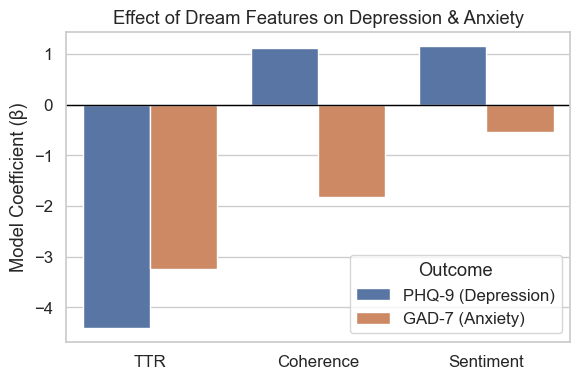

In [45]:
# ======================================================
# DREAM STUDY: Slide-Ready Coefficient Visualization
# ======================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

coef_table = pd.read_csv("chaos_dataset/us_model_coefficients.csv")

# Keep only relevant predictors
plot_df = coef_table.query("Predictor not in ['Intercept','Group Var']").copy()
plot_df = plot_df.melt(
    id_vars=["Predictor"],
    value_vars=["β_PHQ9", "β_GAD7"],
    var_name="Outcome",
    value_name="Coefficient",
)
plot_df["Outcome"] = plot_df["Outcome"].replace(
    {"β_PHQ9": "PHQ-9 (Depression)", "β_GAD7": "GAD-7 (Anxiety)"}
)

sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(6, 4))
sns.barplot(
    data=plot_df,
    x="Predictor",
    y="Coefficient",
    hue="Outcome",
    palette=["#4C72B0", "#DD8452"],
)
plt.axhline(0, color="black", lw=1)
plt.title("Effect of Dream Features on Depression & Anxiety")
plt.ylabel("Model Coefficient (β)")
plt.xlabel("")
plt.legend(title="Outcome")
plt.tight_layout()
plt.savefig("chaos_dataset/fig_coeff_bar_us.png", dpi=300)
plt.show()